## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Create Dataset with Four Class in a CSV File

In [135]:
np.random.seed(0)

def generate_class_data(center_x, center_y, size=100, spread=4.0):
    x1 = np.random.rand(size) * spread + center_x
    x2 = np.random.rand(size) * spread + center_y
    return x1, x2

x1_top, x2_top = generate_class_data(2.5, 4)
x1_bottom, x2_bottom = generate_class_data(1, -5)
x1_left, x2_left = generate_class_data(-3,2)
x1_right, x2_right = generate_class_data(5, 0)

#Labels
label_top = np.full(100, 0)
label_bottom = np.full(100, 1)
label_left = np.full(100, 2)
label_right = np.full(100, 3)

x1 = np.concatenate([x1_top, x1_bottom, x1_left, x1_right])
x2 = np.concatenate([x2_top, x2_bottom, x2_left, x2_right])
labels = np.concatenate([label_top, label_bottom, label_left, label_right])

df = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'label': labels
})

df.to_csv('four_class_dataset.csv', index=False)
print("CSV file 'four_class_dataset.csv' created.")

CSV file 'four_class_dataset.csv' created.


## Dataset Visualization

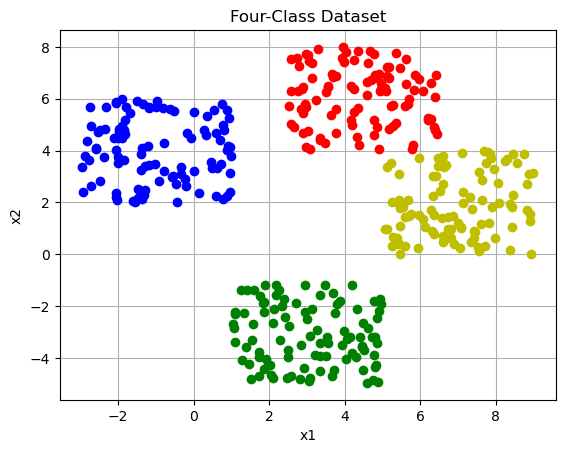

In [137]:
plt.figure()

for i in range(len(df)):
    if df['label'][i] == 0:
        plt.plot(df['x1'][i], df['x2'][i], "ro") 
    elif df['label'][i] == 1:
        plt.plot(df['x1'][i], df['x2'][i], "go") 
    elif df['label'][i] == 2:
        plt.plot(df['x1'][i], df['x2'][i], "bo")
    else:
        plt.plot(df['x1'][i], df['x2'][i], "yo") 

plt.title("Four-Class Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()


## Features and Labels

In [139]:
df = pd.read_csv('four_class_dataset.csv')
X = df[['x1', 'x2']].values
Y = df[['label']].values

encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y)

## Neural Network

In [153]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 2
        hiddenLayerNeurons1 = 30
        hiddenLayerNeurons2 = 20
        hiddenLayerNeurons3 = 10
        outputLayerNeurons = 4

        self.learning_rate = 0.005
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayerNeurons1)
        self.W_H2 = np.random.randn(hiddenLayerNeurons1, hiddenLayerNeurons2)
        self.W_H3 = np.random.randn(hiddenLayerNeurons2, hiddenLayerNeurons3)
        self.W_OH = np.random.randn(hiddenLayerNeurons3, outputLayerNeurons)
        

    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1-x)

        else:
            return 1 / (1 + np.exp(-x))


    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        

    def feedForward(self, X):
        hidden_input1 = np.dot(X, self.W_H1)
        self.hidden_output1 = self.sigmoid(hidden_input1)

        hidden_input2 = np.dot(self.hidden_output1, self.W_H2)
        self.hidden_output2 = self.sigmoid(hidden_input2)

        hidden_input3 = np.dot(self.hidden_output2, self.W_H3)
        self.hidden_output3 = self.sigmoid(hidden_input3)

        output_input = np.dot(self.hidden_output3, self.W_OH)
        pred = self.softmax(output_input)
        return pred


    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error

        hidden_error3 = output_delta.dot(self.W_OH.T)
        hidden_delta3 = self.learning_rate * hidden_error3 * self.sigmoid(self.hidden_output3, der=True)

        hidden_error2 = hidden_delta3.dot(self.W_H3.T)
        hidden_delta2 = self.learning_rate * hidden_error2 * self.sigmoid(self.hidden_output2, der=True)

        hidden_error1 = hidden_delta2.dot(self.W_H2.T)
        hidden_delta1 = self.learning_rate * hidden_error1 * self.sigmoid(self.hidden_output1, der=True)

        self.W_H1 += X.T.dot(hidden_delta1)
        self.W_H2 += self.hidden_output1.T.dot(hidden_delta2)
        self.W_H3 += self.hidden_output2.T.dot(hidden_delta3)
        self.W_OH += self.hidden_output3.T.dot(output_delta)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)


## Accuracy and Loss

Training Accuracy: 0.996875
Testing Accuracy: 0.9875
Final Loss: 0.004671652661172804


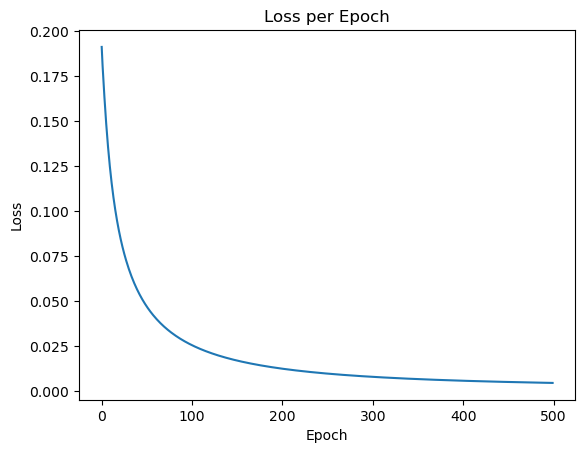

In [155]:
NN = NeuralNetwork()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

err = []
for epoch in range(500):
    NN.train(X_train, Y_train)
    loss = np.mean(np.square(Y - NN.feedForward(X)))
    err.append(loss)

train_pred = np.argmax(NN.feedForward(X_train), axis=1)
test_pred = np.argmax(NN.feedForward(X_test), axis=1)
Y_train_labels = np.argmax(Y_train, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

train_accuracy = accuracy_score(Y_train_labels, train_pred)
test_accuracy = accuracy_score(Y_test_labels, test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')
   
print(f"Final Loss: {err[-1]}")

plt.plot(err)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## Confusion Matrix

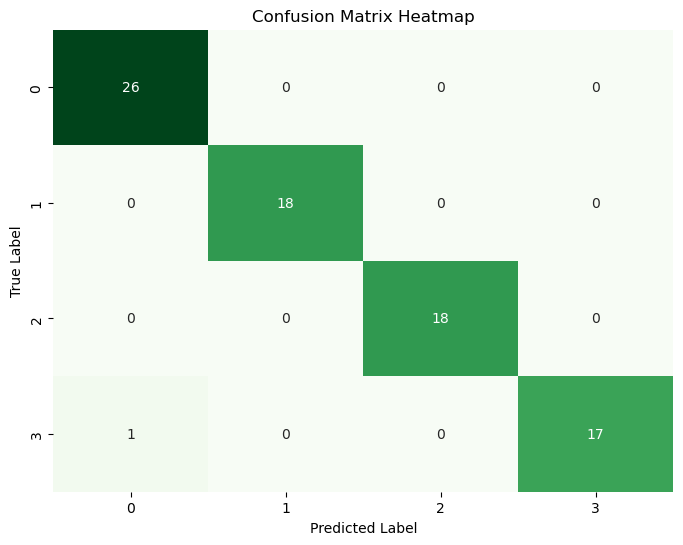

In [157]:
cm = confusion_matrix(Y_test_labels, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()